In [9]:
# code adapted from https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from cloudmesh.common.StopWatch import StopWatch

df=pd.read_csv("C:/Users/Sledgehammer/Desktop/EOS-USD.csv")
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (1468, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-01,1.031340,1.07176,0.989566,1.00669,1.00669,13613000.0
1,2017-07-02,0.996521,2.87751,0.822648,2.71005,2.71005,320452000.0
2,2017-07-03,2.717390,5.39597,2.632310,4.08664,4.08664,414950016.0
3,2017-07-04,4.098010,4.19124,2.933450,3.37200,3.37200,218559008.0
4,2017-07-05,3.356000,3.52350,2.730130,3.00323,3.00323,124339000.0


In [10]:
df.isnull()
df1 = df.dropna(axis=0, how="any")
df1.shape
# from math import nan
# from datatest import validate, accepted, Extra


# data = [df, float('nan')]
# requirement = {5, 6}

# with accepted(Extra(nan)):
#    validate(data, requirement)


(1464, 7)

In [11]:
# Use open through volume
# test taking out adj close later
training_set = df1.iloc[:1120, [1,2,3,5,6]].values
test_set = df1.iloc[1121:, [1,2,3,5,6]].values
training_set[0:5,:]

array([[1.03134000e+00, 1.07176000e+00, 9.89566000e-01, 1.00669000e+00,
        1.36130000e+07],
       [9.96521000e-01, 2.87751000e+00, 8.22648000e-01, 2.71005000e+00,
        3.20452000e+08],
       [2.71739000e+00, 5.39597000e+00, 2.63231000e+00, 4.08664000e+00,
        4.14950016e+08],
       [4.09801000e+00, 4.19124000e+00, 2.93345000e+00, 3.37200000e+00,
        2.18559008e+08],
       [3.35600000e+00, 3.52350000e+00, 2.73013000e+00, 3.00323000e+00,
        1.24339000e+08]])

## Min-max scaling for normalization

In [5]:
# This cell works perfectly fine, we are simply going to experiment with unnormalizing the data
# in the next cell

# np.max(training_set[:,0])
# print(type(training_set))
# type(training_set[0,0])
## Normalize between -1.0 and +1.0
# training_set_scaled = np.empty(training_set.shape)
# test_set_scaled = np.empty(test_set.shape)
# for i in range(5):
#    training_set_scaled[:,i] = training_set[:,i]/abs(training_set[:,i]).max()
#    test_set_scaled[:,i] = test_set[:,i]/abs(test_set[:,i]).max()
# print(training_set[0:5,:])

<class 'numpy.ndarray'>
[[1.03134000e+00 1.07176000e+00 9.89566000e-01 1.00669000e+00
  1.36130000e+07]
 [9.96521000e-01 2.87751000e+00 8.22648000e-01 2.71005000e+00
  3.20452000e+08]
 [2.71739000e+00 5.39597000e+00 2.63231000e+00 4.08664000e+00
  4.14950016e+08]
 [4.09801000e+00 4.19124000e+00 2.93345000e+00 3.37200000e+00
  2.18559008e+08]
 [3.35600000e+00 3.52350000e+00 2.73013000e+00 3.00323000e+00
  1.24339000e+08]]


In [12]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)
print(training_set_scaled[0:5, :])

[[0.0254678  0.02472329 0.02768736 0.02439336 0.00090473]
 [0.02382123 0.10543895 0.01861435 0.10531547 0.03155752]
 [0.10520039 0.2180122  0.1169805  0.17071361 0.04099775]
 [0.17048933 0.16416168 0.13334929 0.13676296 0.02137855]
 [0.13539999 0.13431421 0.12229761 0.11924368 0.0119661 ]]


In [22]:
print(training_set_scaled.shape)

(1120, 5)


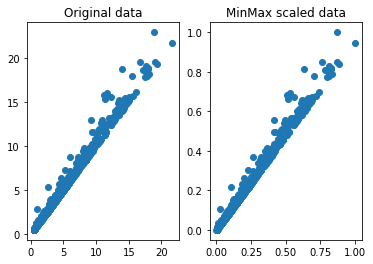

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2)

axes[0].scatter(training_set[:,0], training_set[:,1])
axes[0].set_title("Original data")

axes[1].scatter(training_set_scaled[:,0], training_set_scaled[:,1])
axes[1].set_title("MinMax scaled data")

plt.show()

In [14]:
# Feature Scaling
# sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(len(X_train))
print(len(y_train))
print(X_train.shape)
print(y_train.shape)
#(740, 60, 1)

740
740
(740, 60, 1)
(740,)


In [15]:
StopWatch.start("Training time")
# try changing the number of epochs and timestep instead of 60, try 70 or 20 (in previous cell)
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

StopWatch.stop("Training time")
StopWatch.benchmark()

Epoch 1/100
24/24 [==============================] - 15s 52ms/step - loss: 0.0404

In [16]:
# Getting the predicted stock price of 2017
# dataset_train = df1.iloc[:1120, [1,2,3,5,6]]
# dataset_test = df1.iloc[1121:, [1,2,3,5,6]]

# dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
dataset_total = np.concatenate((training_set_scaled, test_set_scaled), axis=0)

inputs = dataset_total[0:len(dataset_total) - len(test_set_scaled) - 60,:]
len(inputs)

1060

In [17]:
print(test_set_scaled.shape)
print(training_set_scaled.shape)

(343, 5)
(1120, 5)


In [24]:
# inputs = inputs.reshape(-1,1)
# inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(60, 343):
    X_test.append(test_set_scaled[i-60:i, 0])
    y_test.append(test_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)
print(type(test_set_scaled))
# (459, 60, 1)

(283, 60, 1)
<class 'numpy.ndarray'>


In [21]:
print(X_test.shape)
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

(283, 60, 1)


ValueError: non-broadcastable output operand with shape (283,1) doesn't match the broadcast shape (283,5)

In [35]:
# resolve = np.append(X_test,predicted_stock_price,1)
print(resolve.shape)
print(X_test.shape)
print(predicted_stock_price.shape)

(17263,)
(283, 60, 1)
(283, 1)


In [13]:
print(predicted_stock_price[1:5,:])

[[0.1774395 ]
 [0.17774032]
 [0.17914201]
 [0.18072343]]


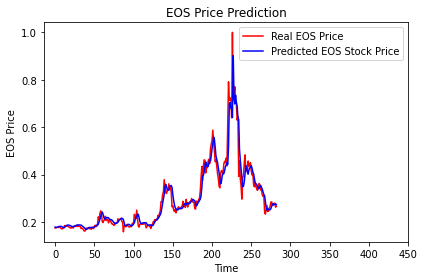

In [15]:
# Visualising the results
# plt.plot(df.loc[1170:,"Date"],y_test, color = 'red',
# label = 'Real EOS Price')
plt.plot(range(0,len(y_test)),y_test, color = 'red',
label = 'Real EOS Price')
# plt.plot(df.loc[1009:, "Date"],predicted_stock_price, color = 'blue',
# label = 'Predicted EOS Stock Price')
plt.plot(range(0,len(predicted_stock_price)),predicted_stock_price, color = 'blue',
label = 'Predicted EOS Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('EOS Price Prediction')
plt.xlabel('Time')
plt.ylabel('EOS Price')
plt.legend()
plt.tight_layout()
plt.savefig("C://Users//Sledgehammer//Desktop//eos_lstm.png", dpi=100, facecolor="#FFFFFF")

In [18]:
# print(len(test_set_scaled))
# print(len(test_set))
# print(len(predicted_stock_price))
# print(test_set_scaled.shape)
print(X_test)
print(y_test)
print(X_train.shape)
print(y_train.shape)
print(X_train[0,:])
print(y_train[0])

[[[0.1871904 ]
  [0.19632482]
  [0.20652704]
  ...
  [0.17348077]
  [0.17778144]
  [0.16842277]]

 [[0.19632482]
  [0.20652704]
  [0.20879565]
  ...
  [0.17778144]
  [0.16842277]
  [0.17518084]]

 [[0.20652704]
  [0.20879565]
  [0.21039466]
  ...
  [0.16842277]
  [0.17518084]
  [0.17583994]]

 ...

 [[0.60263388]
  [0.79144551]
  [0.71621496]
  ...
  [0.27112859]
  [0.27085502]
  [0.27927398]]

 [[0.79144551]
  [0.71621496]
  [0.71304341]
  ...
  [0.27085502]
  [0.27927398]
  [0.28018748]]

 [[0.71621496]
  [0.71304341]
  [0.72397178]
  ...
  [0.27927398]
  [0.28018748]
  [0.26310454]]]
[0.17518084 0.17583994 0.17760969 0.17855057 0.17727589 0.1794224
 0.17807095 0.17551526 0.17140352 0.17165847 0.1741845  0.17462666
 0.18584971 0.18284462 0.18238335 0.18278999 0.18265692 0.18022277
 0.1793806  0.17564846 0.1747938  0.17640509 0.17872812 0.17504992
 0.18072156 0.18469072 0.18227747 0.18281247 0.18585641 0.18131382
 0.18376915 0.1831144  0.18127264 0.17282685 0.17390107 0.17326273
 0.16

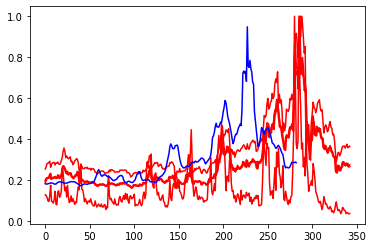

In [19]:
plt.plot(test_set_scaled, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')